In [2]:
from collections import defaultdict
from matplotlib import pyplot as plt
from adjustText import adjust_text
import scienceplots

## Nature用設定 ##
plt.style.use(['science','nature','sans','no-latex','std-colors'])
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (2,2)
# 軸
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['xtick.major.top'] = False
plt.rcParams['xtick.minor.top'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['ytick.major.right'] = False
plt.rcParams['ytick.minor.right'] = False
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# 文字
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
plt.rcParams['legend.fontsize'] = 5
# その他
plt.rcParams['axes.grid'] = False
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

import math
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",50)
import pickle

from scipy import stats
from scipy.stats import spearmanr,ttest_1samp, pearsonr

import configparser
config = configparser.ConfigParser()
config.read('./config.ini', encoding='utf-8')
SAVE_DIR = config.get('settings','SAVE_DIR')
WORK_DIR = config.get('settings','WORK_DIR')
SHARE_DIR = config.get('settings','SHARE_DIR')

settings = configparser.ConfigParser()
settings.read('./settings.ini', encoding='utf-8')
MIN_YEAR = int(settings.get('experiment','MIN_YEAR'))
MAX_YEAR = int(settings.get('experiment','MAX_YEAR'))
RESOLUTION = float(settings.get('experiment','RESOLUTION'))
NMIN = int(settings.get('experiment','NMIN'))
RESOLUTION_TOPIC = float(settings.get('experiment','RESOLUTION_TOPIC'))
NMIN_TOPIC = int(settings.get('experiment','NMIN_TOPIC'))

In [3]:
papers = pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_2016_all_validread.pickle')
for year in range(2016,2022):
    papers[f'c_history_sum_{year}'] = papers['c_history'].map(lambda l: sum(l[:year-2015]))

In [4]:
papers_hcp = papers[papers['label_hml_2021'].isin(['top'])]
papers_mcp = papers[papers['label_hml_2021'].isin(['middle'])]
papers_lcp = papers[papers['label_hml_2021'].isin(['bottom'])]
papers_slow = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['top']))]
papers_fast = papers[(papers['label_hml_2018'].isin(['top']))&(papers['label_hml_2021'].isin(['top']))]
papers_low = papers[(papers['label_hml_2018'].isin(['middle','bottom']))&(papers['label_hml_2021'].isin(['middle','bottom']))]

papers_slow_lowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_lowmatched2018_journal.pickle').index]
papers_low_slowmatched2018_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_low_1e-06_slowmatched2018_journal.pickle').index]
papers_slow_fastmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_slow_1e-06_fastmatched2021_journal.pickle').index]
papers_fast_slowmatched2021_journal = papers.loc[pd.read_pickle('/disks/qnap2/data/t-miura/2023_readership/final_paper/papers_fast_1e-06_slowmatched2021_journal.pickle').index]

_ = pd.read_excel(
     SAVE_DIR+f'paper_detail/keywords_in_2021_{RESOLUTION}_{NMIN}_tficf_waltman_name.xlsx', 
     sheet_name='names'
 )[['partition','n_1970-2021','n_2016','nameByGPT-4'] + [f'word{i}' for i in range(5)]]
keywords = {int(k):v for k,v in _.set_index('partition')['nameByGPT-4'].to_dict().items()}
MAX_PARTITION = 47 

colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])[[0,1,2,3]]
with open(SAVE_DIR+f'paper_detail/partition_to_ASJC_in_2021_{RESOLUTION}_{NMIN}.pickle','rb') as f:
    pid_to_largefield = pickle.load(f)

target_partitions = []
for i in [3,1,0,2]:
    target_partitions.extend([k for k,v in pid_to_largefield.items() if (v == i) & (k < MAX_PARTITION+1) & (k != -1)])
target_partitions_dic = {k:i+1 for i,k in enumerate(target_partitions)}

asjc_name = {
    0: 'Health Sciences',
    1: 'Life Sciences',
    2: 'Physical Sciences',
    3: 'Social Sciences'
}

# correlation

In [7]:
papers.columns

Index(['eid', 'authids', 'subjs', 'doi', 'doctype', 'journal', 'c_history',
       'c_history_sum', 'c_normalized_1e-06', 'CD', 'partition_1e-06',
       'c_history_sum_2018', 'jif', 'partition_0.0005', 'partition_ASJC',
       'cumulative_reader_2016', 'cumulative_reader_2017',
       'cumulative_reader_2018', 'cumulative_reader_2019',
       'cumulative_reader_2020', 'cumulative_reader_2021',
       'cumulative_reader_2022', 'read_percite_2016', 'read_percite_2017',
       'read_percite_2018', 'read_percite_2019', 'read_percite_2020',
       'read_percite_2021', 'read_percite_2022', 'auth_prestige', 'D_nok',
       'label_hml_2018', 'label_hml_2021', 'capacity', 'c_history_sum_2016',
       'c_history_sum_2017', 'c_history_sum_2019', 'c_history_sum_2020',
       'c_history_sum_2021'],
      dtype='object')

(2290742, 39)
[[1.         0.51998192]
 [0.51998192 1.        ]]


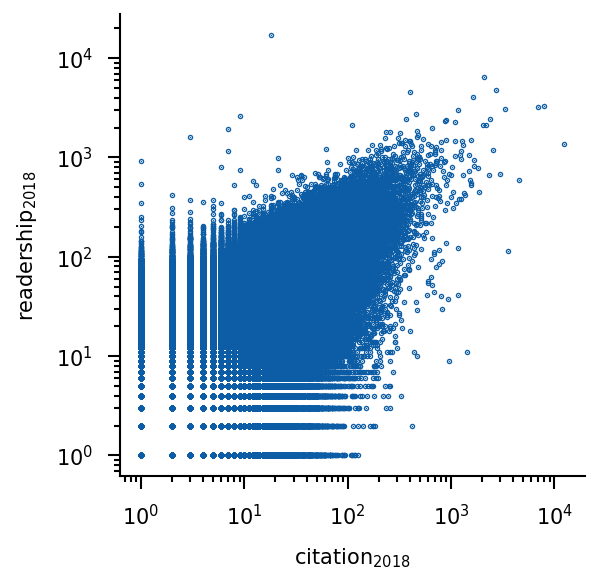

In [12]:
print(papers.shape)
fig,ax = plt.subplots()
ax.scatter(papers['c_history_sum_2018'],papers['cumulative_reader_2018'],s=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('citation$_{2018}$')
ax.set_ylabel('readership$_{2018}$')
print(np.corrcoef(papers['c_history_sum_2018'],papers['cumulative_reader_2018']))
plt.show()

(2290742, 39)
[[1.         0.49543944]
 [0.49543944 1.        ]]


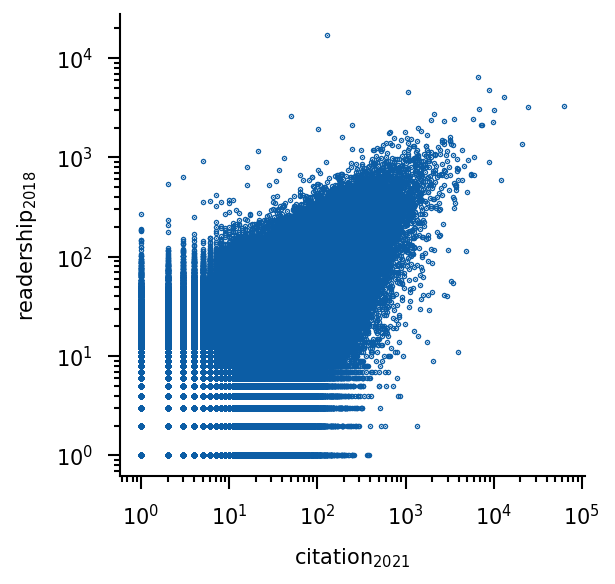

In [13]:
print(papers.shape)
fig,ax = plt.subplots()
ax.scatter(papers['c_history_sum_2021'],papers['cumulative_reader_2018'],s=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('citation$_{2021}$')
ax.set_ylabel('readership$_{2018}$')
print(np.corrcoef(papers['c_history_sum_2021'],papers['cumulative_reader_2018']))
plt.show()

# 0. The number of SCP

In [4]:
n_field_asjc = defaultdict(int)
for i in [3,1,0,2]:
    print(i)
    for k,v in pid_to_largefield.items():
        if k in target_partitions:
            if k == -1: continue
            if v == i:
                n_field_asjc[i] += 1
                print('\t',k, keywords[k])

3
	 3.0 Social & Political Sciences
	 32.0 History & Cultural Studies
	 33.0 Operations Research & Logistics
	 46.0 Classics & Ancient History
1
	 0.0 Molecular & Cellular Biology
	 4.0 Ecology & Evolution
	 5.0 Nutrition & Microbiome
	 16.0 Plant Science & Stress Responses
0
	 1.0 Neuropsychiatric Disorders
	 8.0 Cardiovascular Medicine
	 10.0 Biomaterials & Orthopedics
	 20.0 Gastroenterology & Surgery
	 21.0 Respiratory & Critical Care Medicine
	 28.0 Autoimmune & Inflammatory Diseases
	 29.0 Healthcare & Medical Education
	 34.0 Orthopedics & Biomechanics
	 35.0 Virology & Vaccines
	 37.0 Urology & Pelvic Health
	 39.0 Infectious Diseases & HIV
	 40.0 Ophthalmology & Vision Disorders
	 41.0 Neurosurgical Disorders
	 42.0 Obstetrics & Gynecology
	 43.0 Parasitic Diseases
2
	 2.0 Organic & Inorganic Chemistry
	 6.0 Nanomaterials & Energy Storage
	 7.0 Computer Vision & Security
	 9.0 Wireless Networks & Security
	 11.0 Fluid Mechanics & Heat Transfer
	 12.0 Astronomy & Astrophysics
	

In [5]:
partition_counts_hcp = papers_hcp.value_counts('partition_1e-06').sort_index()
partition_counts_slow = papers_slow.value_counts('partition_1e-06').sort_index()
partition_counts = pd.concat([partition_counts_hcp, partition_counts_slow], axis=1)
partition_counts.columns = ['hcp','scp']
partition_counts = partition_counts.loc[target_partitions]

48 48


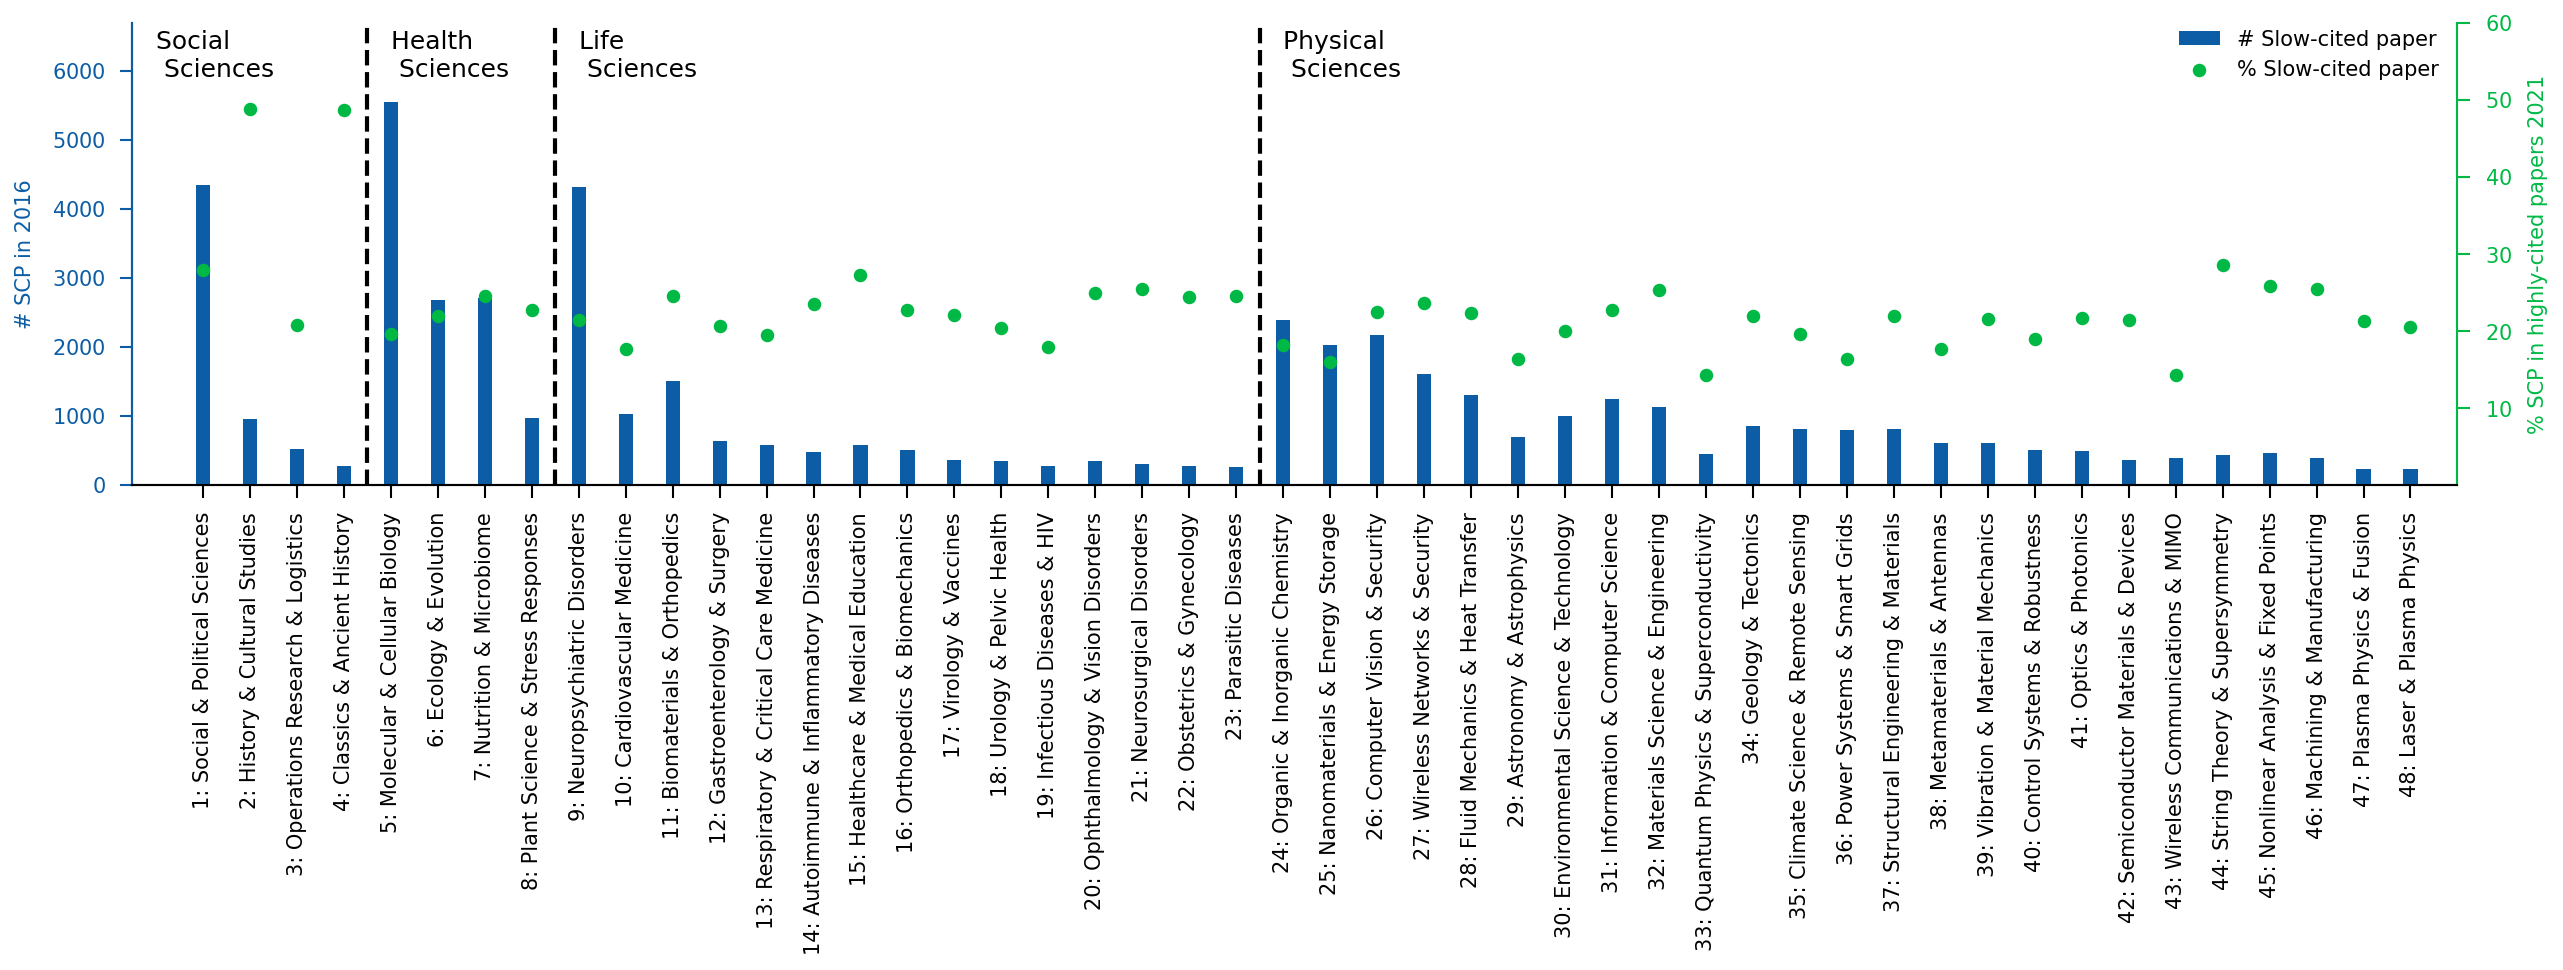

In [6]:
x1 = range(len(partition_counts.index))
y1 = partition_counts['hcp'].values
y2 = partition_counts['scp'].values
print(len(y1),len(y2))

fig,ax = plt.subplots(figsize=(10,2))
ax.bar(x1,y2,width=0.3,align='center', label='# Slow-cited paper', zorder=5)
ax.tick_params(axis='both',labelsize=5)
ax.set_xticks(x1)
ax.set_xticklabels([f'{target_partitions_dic[i]}: ' + keywords.get(i,'') for i in target_partitions],rotation=90)
ax.set_ylabel(r'# SCP in 2016', color=COLOR_CYCLE[0])

plt.rcParams['axes.spines.right'] = True
ax2 = ax.twinx()
ax2.scatter(x1, y2*100/y1, color=COLOR_CYCLE[1], s=5, label='% Slow-cited paper')
ax2.set_ylabel('% SCP in highly-cited papers 2021', color=COLOR_CYCLE[1])

fig.legend(loc='upper right',bbox_to_anchor=(0.9,0.9))

ax.axvline(n_field_asjc[3]-0.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(n_field_asjc[3]+n_field_asjc[1]-0.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(n_field_asjc[3]+n_field_asjc[1]+n_field_asjc[0]-0.5, linestyle='--', linewidth=1, color='black')

TEXT_HEIGHT = 53
plt.text(-1,TEXT_HEIGHT,'Social \n Sciences', fontsize=6)
plt.text(n_field_asjc[3],TEXT_HEIGHT,'Health \n Sciences', fontsize=6)
plt.text(n_field_asjc[3]+n_field_asjc[1],TEXT_HEIGHT,'Life \n Sciences', fontsize=6)
plt.text(n_field_asjc[3]+n_field_asjc[1]+n_field_asjc[0],TEXT_HEIGHT,'Physical \n Sciences', fontsize=6)

# 色の変更
ax2.spines['left'].set_color(COLOR_CYCLE[0])
ax2.spines['right'].set_color(COLOR_CYCLE[1])
ax.tick_params(axis='y', colors=COLOR_CYCLE[0])
ax2.tick_params(axis='y', colors=COLOR_CYCLE[1])

ax.set_xlim(-1.5,MAX_PARTITION+1)
ax.set_ylim(0,6700)
ax2.set_ylim(0.13,60)
# plt.savefig('./scp_field_overview.eps')
plt.show()

plt.rcParams['axes.spines.right'] = False

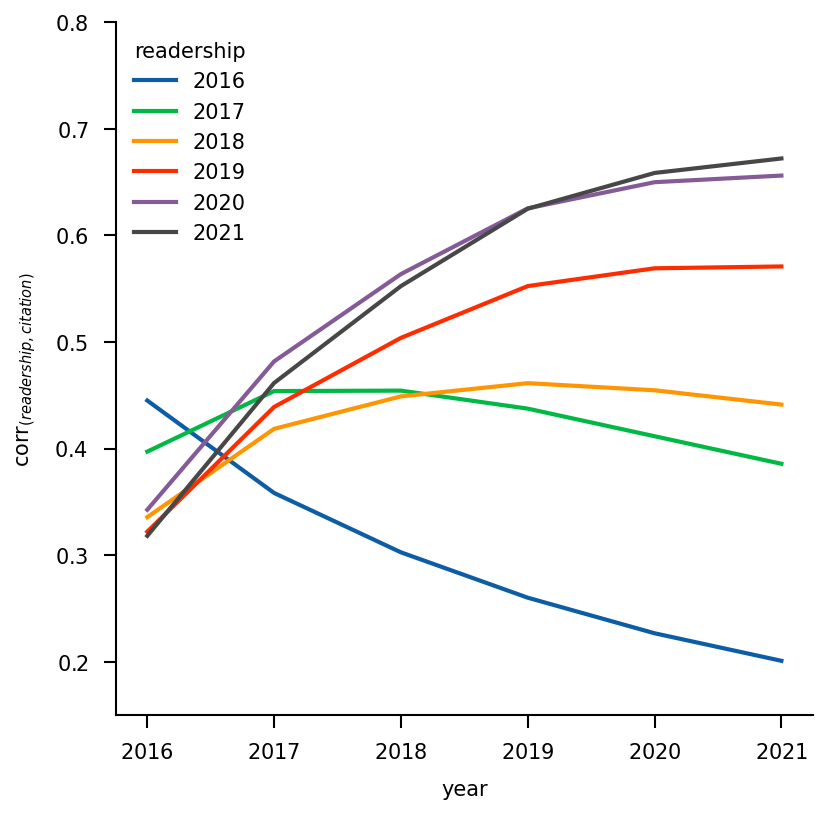

In [7]:
fig,ax = plt.subplots(figsize=(3,3))

x = range(2016,2022)
for read_year in x:
    y = [
        np.corrcoef(papers_hcp[f'cumulative_reader_{read_year}'], papers_hcp['c_history'].map(lambda l: sum(l[:cite_year-2015])))[0,1]
        for cite_year in x
    ]
    ax.plot(x, y, label=read_year, zorder=5)
# ax.set_title('readership vs citation', fontsize=6)
ax.set_xlabel('year')
ax.set_ylabel('corr$_{(readership, citation)}$')

# ax.set_xticks(x)
# ax.set_yticks(ax.get_yticks())
# ax.set_xticklabels(ax.get_xticklabels(),fontsize=6)
# ax.set_yticklabels(ax.get_yticklabels(),fontsize=6)

ax.legend(title='readership', title_fontsize=5)
ax.set_ylim(0.15,0.8)
# plt.savefig('./hcp_cite_read_corr.eps')
plt.show()

# 1. Pairwise analysis

In [1]:
def get_diff(diff_list):
    """get average and confidence interval"""
    np.random.seed(42)
    N_SAMPLE = 651
    diff_list = np.random.choice(diff_list, size=N_SAMPLE)
    val_mean = np.mean(diff_list)
    val_conf = 1.96 * diff_list.std() / np.sqrt(len(diff_list))
    return val_mean, val_conf

## 1.1 log

In [9]:
years = range(2016,2022)

slow_low_diff_reader = {
    year: papers_slow_lowmatched2018_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values - papers_low_slowmatched2018_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_low_diff_citation = {
    year: papers_slow_lowmatched2018_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values - papers_low_slowmatched2018_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_fast_diff_reader = {
    year: papers_slow_fastmatched2021_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values - papers_fast_slowmatched2021_journal[f'cumulative_reader_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

slow_fast_diff_citation = {
    year: papers_slow_fastmatched2021_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values - papers_fast_slowmatched2021_journal[f'c_history_sum_{year}'].map(lambda x: np.log(x+1)).values
    for year in years
}

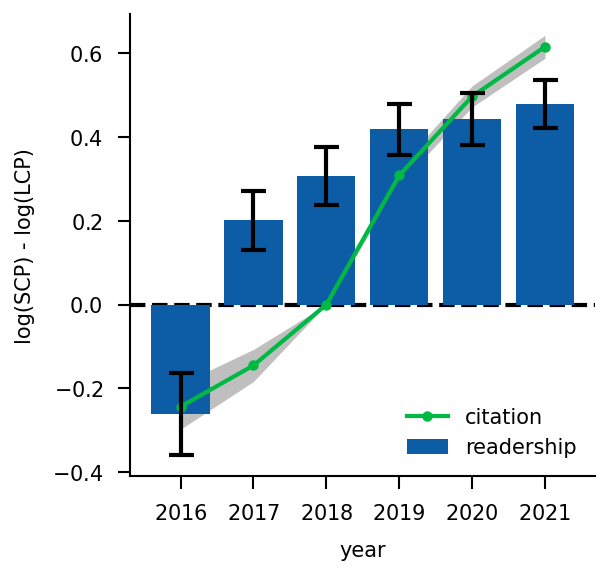

In [10]:
# Match_2018_Journal_slow_low
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_low_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_low_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('log(SCP) - log(LCP)')
ax.legend(loc='lower right')
# ax.grid(alpha=0.2, zorder=-10)
# plt.savefig('./sb_lcp_cohen.pdf')
plt.show()

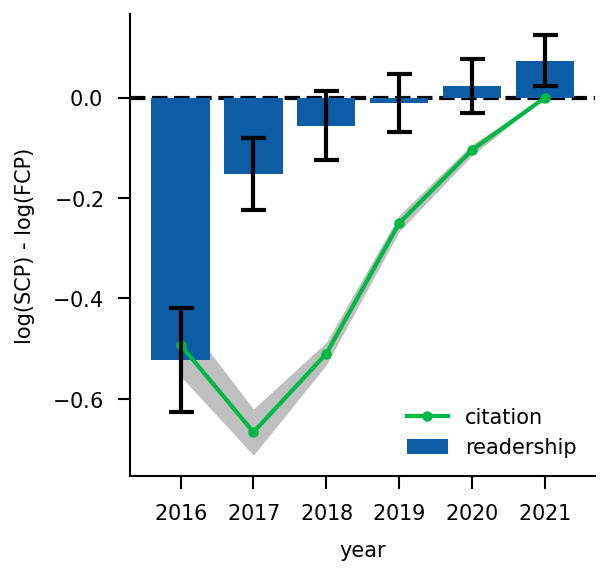

In [11]:
# Match_2021_Journal_fast_slow
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_fast_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_fast_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('log(SCP) - log(FCP)')
ax.legend(loc='lower right')
# ax.grid(alpha=0.2, zorder=-10)
# plt.savefig('./sb_fcp_cohen.pdf')
plt.show()

In [12]:
print('readership')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_reader[year].mean(), np.exp(slow_low_diff_reader[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_reader[year].mean(), np.exp(slow_fast_diff_reader[year].mean()))
print()
print('citation')
for year in range(2016,2022):
    print(f'slow - low({year}): ', slow_low_diff_citation[year].mean(), np.exp(slow_low_diff_citation[year].mean()))
    print(f'slow - fast({year}):', slow_fast_diff_citation[year].mean(), np.exp(slow_fast_diff_citation[year].mean()))

readership
slow - low(2016):  -0.2573831552823059 0.7730719504102366
slow - fast(2016): -0.5055403040648416 0.6031795869858531
slow - low(2017):  0.1785798376276842 1.1955183268105007
slow - fast(2017): -0.14434154807260746 0.8655920562671163
slow - low(2018):  0.29624739771320807 1.3448028168222932
slow - fast(2018): -0.058546443137490536 0.9431344372601551
slow - low(2019):  0.4006396889630456 1.4927793067290467
slow - fast(2019): -0.01588692560521373 0.984238605948067
slow - low(2020):  0.43460565684918456 1.5443539334609042
slow - fast(2020): 0.02374543406008649 1.024029601649249
slow - low(2021):  0.4804495714205025 1.6168011063980061
slow - fast(2021): 0.0589443566287033 1.0607162172717237

citation
slow - low(2016):  -0.20584657153810143 0.8139579510194814
slow - fast(2016): -0.4934116678538817 0.610539877683404
slow - low(2017):  -0.15063249505827475 0.8601637550101721
slow - fast(2017): -0.6127118544584865 0.5418793767360054
slow - low(2018):  0.0 1.0
slow - fast(2018): -0.503

## 1.2 without log

In [38]:
years = range(2016,2022)

slow_low_diff_reader = {
    year: papers_slow_lowmatched2018_journal[f'cumulative_reader_{year}'].values - papers_low_slowmatched2018_journal[f'cumulative_reader_{year}'].values
    for year in years
}

slow_low_diff_citation = {
    year: papers_slow_lowmatched2018_journal[f'c_history_sum_{year}'].values - papers_low_slowmatched2018_journal[f'c_history_sum_{year}'].values
    for year in years
}

slow_fast_diff_reader = {
    year: papers_slow_fastmatched2021_journal[f'cumulative_reader_{year}'].values - papers_fast_slowmatched2021_journal[f'cumulative_reader_{year}'].values
    for year in years
}

slow_fast_diff_citation = {
    year: papers_slow_fastmatched2021_journal[f'c_history_sum_{year}'].values - papers_fast_slowmatched2021_journal[f'c_history_sum_{year}'].values
    for year in years
}

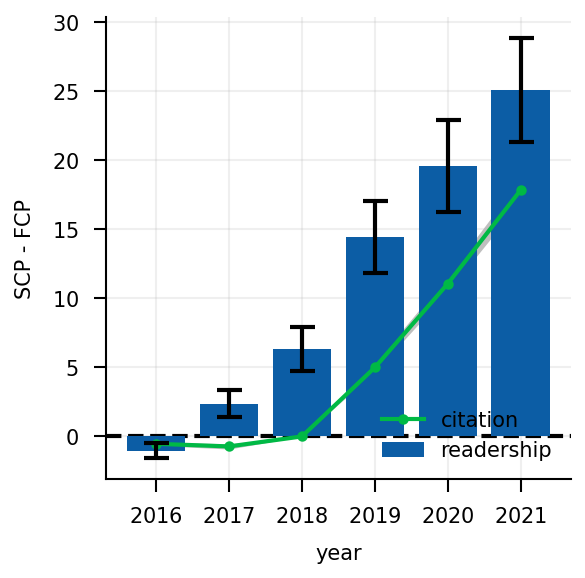

In [39]:
# Match_2018_Journal_slow_low
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_low_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_low_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('SCP - FCP')
ax.legend(loc='lower right')
ax.grid(alpha=0.2, zorder=-10)
# plt.savefig('../doc/figs_update_11/sb_lcp_cohen.pdf')
plt.show()

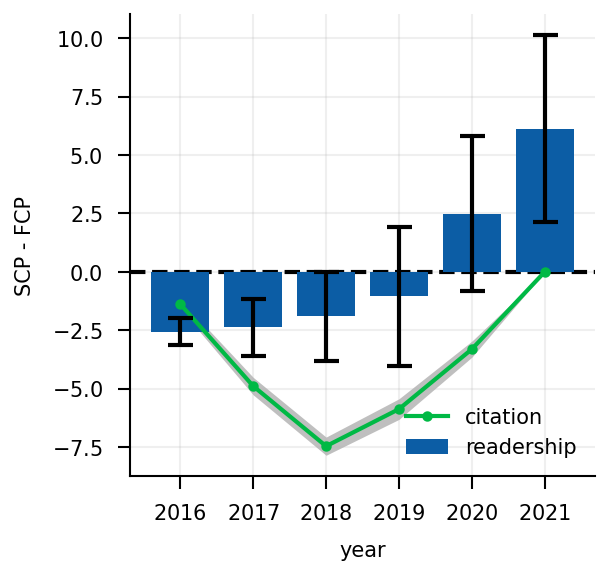

In [40]:
# Match_2021_Journal_fast_slow
diff_means_reader = []
diff_confs_reader = []
for year, diff_list in slow_fast_diff_reader.items():
    mean, conf = get_diff(diff_list)
    diff_means_reader.append(mean)
    diff_confs_reader.append(conf)

diff_means_citation = []
diff_confs_citation = []
for year, diff_list in slow_fast_diff_citation.items():
    mean, conf = get_diff(diff_list)
    diff_means_citation.append(mean)
    diff_confs_citation.append(conf)
diff_means_citation = np.array(diff_means_citation)
diff_confs_citation = np.array(diff_confs_citation)

fig,ax = plt.subplots(figsize=(2,2))
ax.bar(years,diff_means_reader,yerr=diff_confs_reader, color=COLOR_CYCLE[0], align='center', capsize=3, ecolor='black', label='readership', zorder=5)
ax.plot(years,diff_means_citation, color=COLOR_CYCLE[1], marker='.', label='citation', zorder=5)
ax.fill_between(years,diff_means_citation-diff_confs_citation,diff_means_citation+diff_confs_citation, alpha=0.5,color='gray', linewidth=0)
ax.axhline(0, linestyle='--', color='black')
ax.set_xlabel('year')
ax.set_ylabel('SCP - FCP')
ax.legend(loc='lower right')
ax.grid(alpha=0.2, zorder=-10)
# plt.savefig('../doc/figs_update_11/sb_fcp_cohen.pdf')
plt.show()

# 2. Field analysis

In [35]:
def calc_conf(arr):
    '''
    1次元配列から、平均値・正規分布を仮定した標準誤差、95%信頼区間にする場合は1.96*標準誤差にすること
    '''
    arr_mean = np.mean(arr)
    arr_err = (np.std(arr, ddof=1) / np.sqrt(len(arr))) # = arr.sem()
    return arr_mean, arr_err*1.96

In [36]:
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    print(partition, len(readers_slow_matched)) #各マッチ数
    mean, err = calc_conf(readers_slow_matched - readers_low_matched)
    y.append(mean) 
    y_err.append(err)

3.0 3090
32.0 674
33.0 351
46.0 190
0.0 4362
4.0 2231
5.0 1979
16.0 731
1.0 3129
8.0 730
10.0 1070
20.0 443
21.0 379
28.0 287
29.0 398
34.0 335
35.0 195
37.0 210
39.0 152
40.0 258
41.0 174
42.0 177
43.0 178
2.0 2021
6.0 1643
7.0 1527
9.0 1118
11.0 1042
12.0 614
13.0 792
14.0 755
15.0 950
17.0 356
18.0 708
19.0 608
22.0 646
23.0 690
24.0 490
25.0 487
26.0 365
27.0 375
30.0 292
31.0 276
36.0 354
38.0 328
44.0 260
45.0 160
47.0 160


全体平均 0.2775652192816415


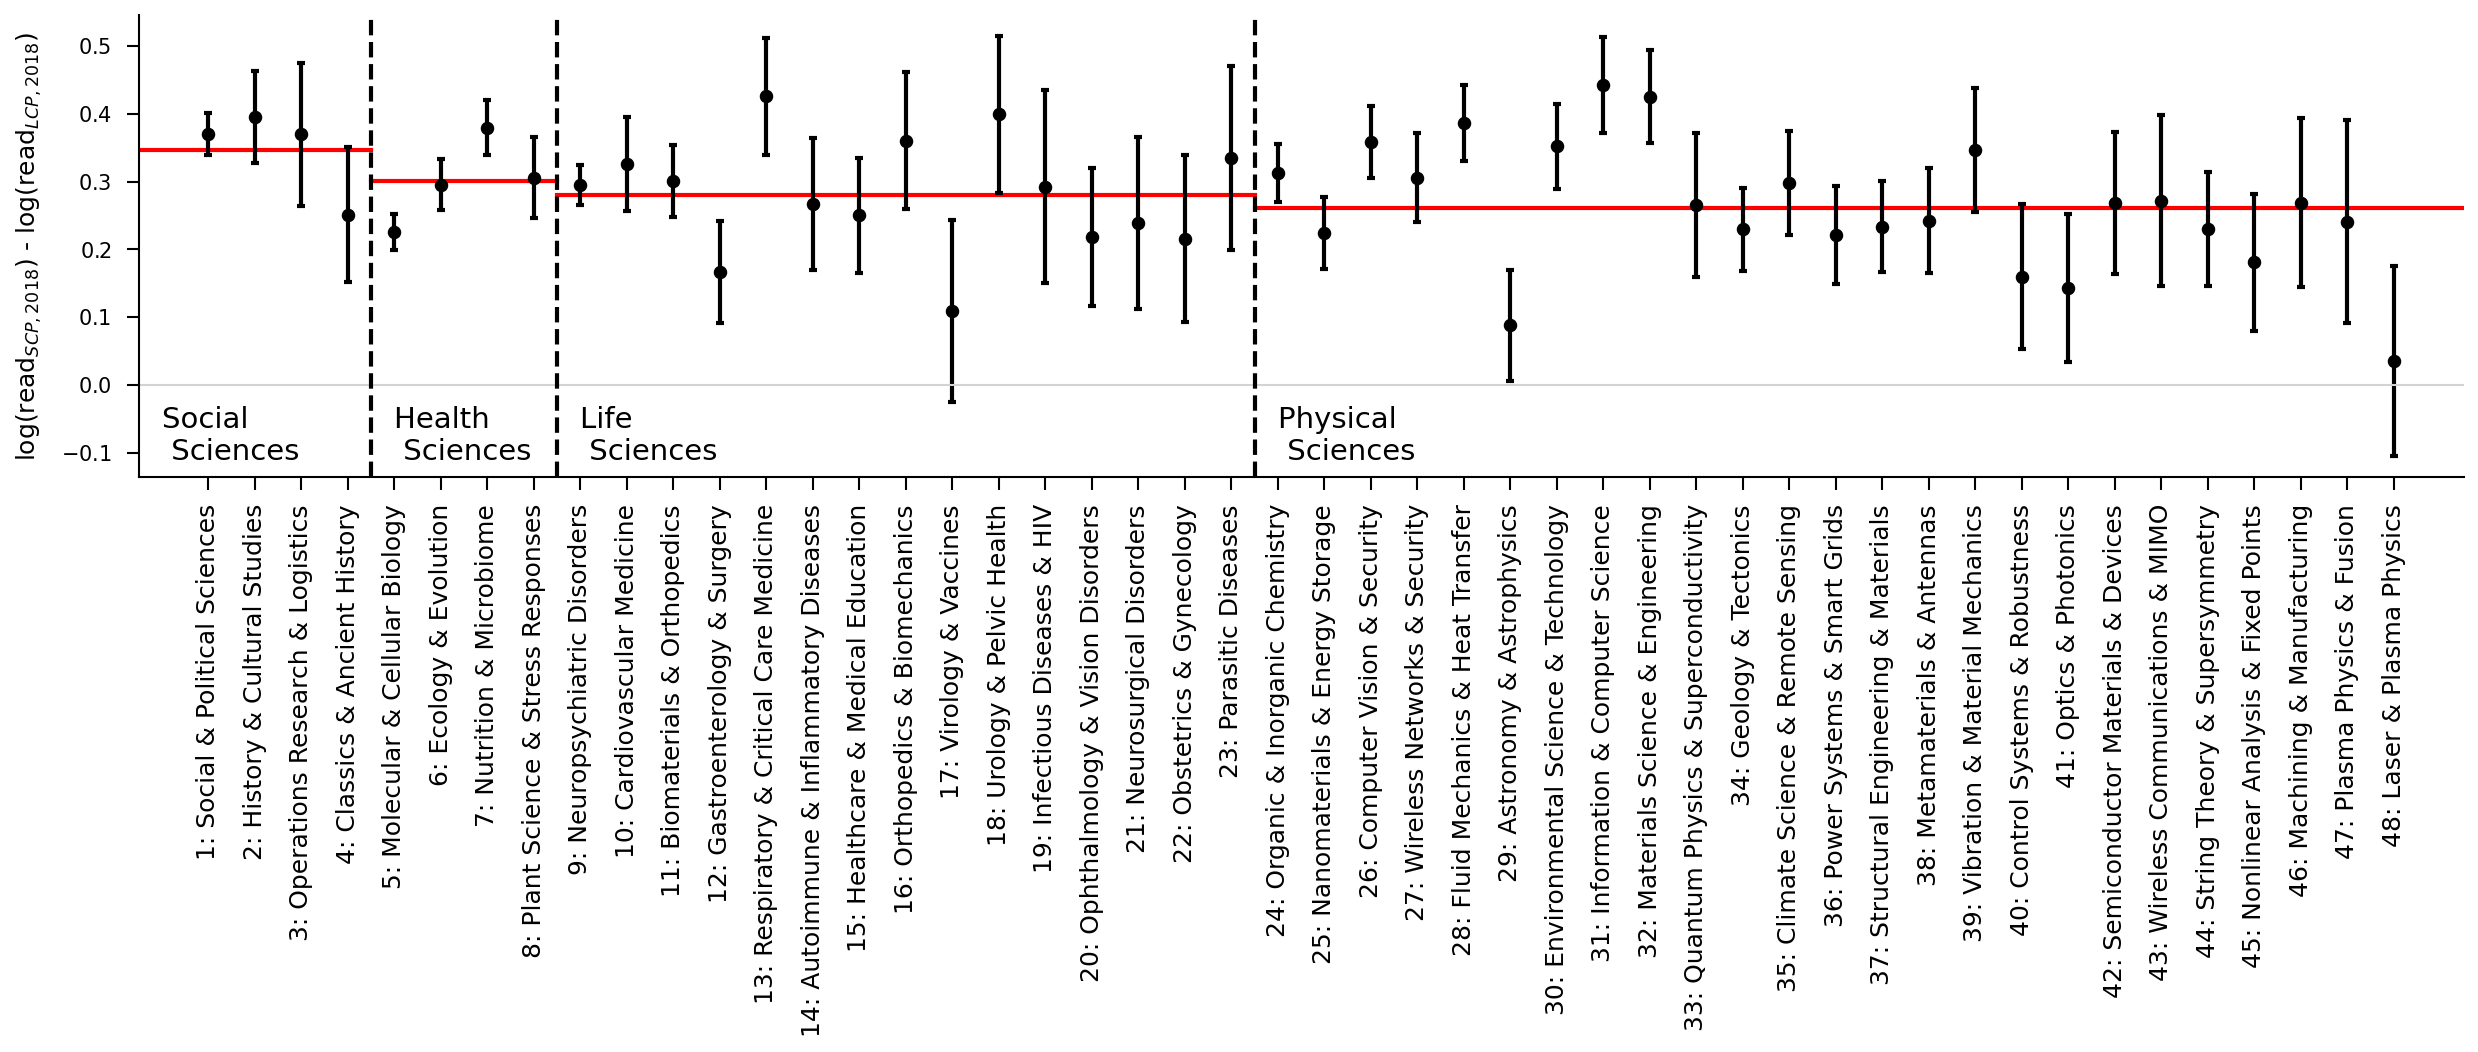

In [15]:
fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.11,'Social \n Sciences')
plt.text(4,-0.11,'Health \n Sciences')
plt.text(8,-0.11,'Life \n Sciences')
plt.text(23,-0.11,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

# plt.savefig('../doc/figs_update_11/scp_lcp_field.eps')
plt.show()

## 2.1 corr

r,p= PearsonRResult(statistic=0.15983194074616555, pvalue=0.2886719473529927)


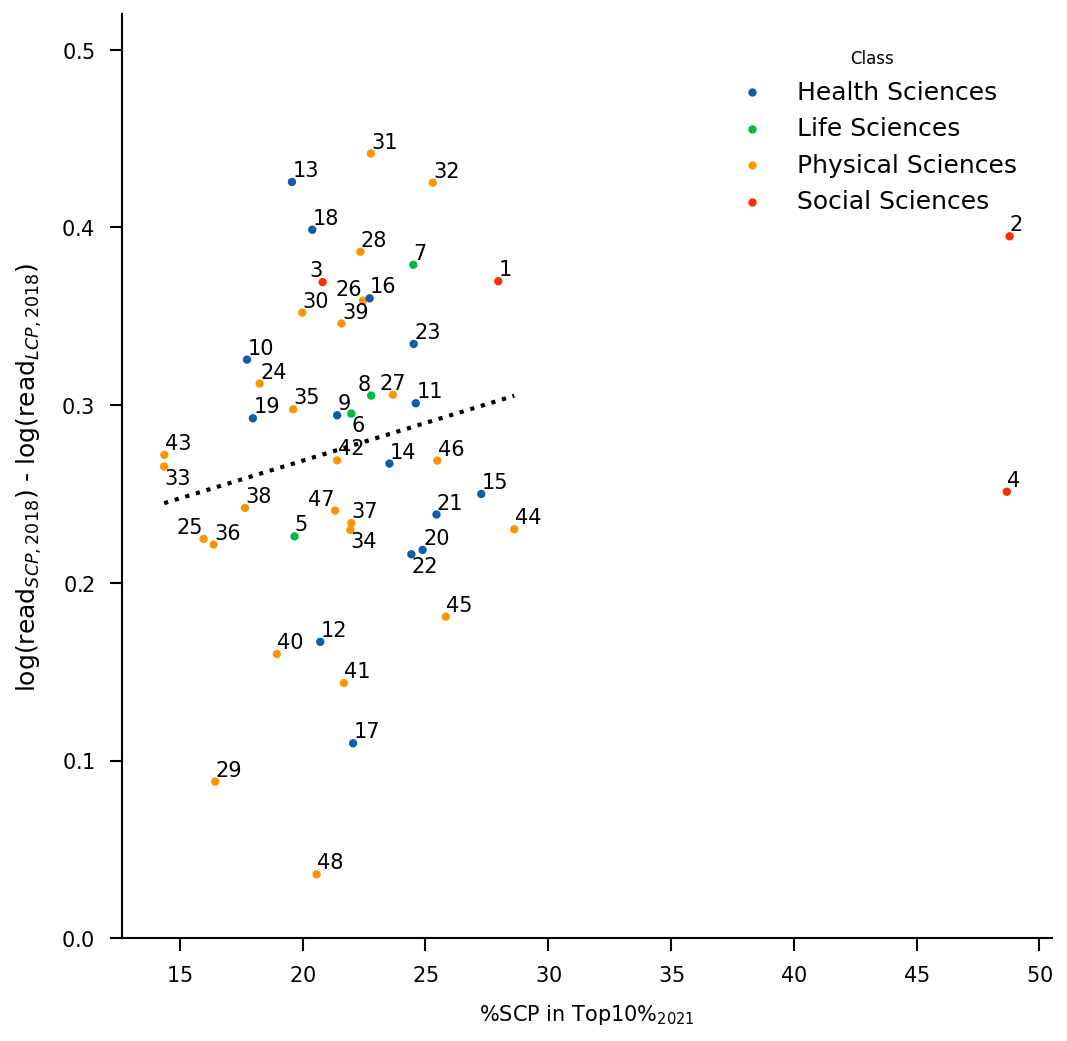

In [58]:
x,y,c = [],[],[]

for partition in range(MAX_PARTITION+1):
    c.append(COLOR_CYCLE[pid_to_largefield[partition]]) #ノードの色
    
    df_slow = papers_slow.query(f'`partition_1e-06` == {partition}')
    df_fast = papers_fast.query(f'`partition_1e-06` == {partition}')
    
    x.append(len(df_slow)*100/(len(df_slow)+len(df_fast))) # マッチしたものだけでなく全体で、2021年のtopに占める、2018年のnot topの割合

    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    y.append((readers_slow_matched - readers_low_matched).mean()) #マッチしたものについて、slowをよく読む割合。つまり、今は低くても後々伸びる論文をよく読む強さ
    # journal matchに変更したこと、logとって平均に変更したこと

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,s=1,c=c)
ax.set_xlabel('%SCP in Top10%$_{2021}$')
ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)',fontsize=6)

texts = [ax.text(xx, yy, target_partitions_dic[partition], ha='center', va='center',fontsize=5) for xx,yy,partition in zip(x,y,range(MAX_PARTITION+1))]
adjust_text(texts,force_text=(0.1,0.3),arrowprops=dict(arrowstyle='-', color='gray',linewidth=0.1))

# 2と4を除いた相関係数, 近似直線
x_wo24 = [xx for xx,partition in zip(x,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
y_wo24 = [yy for yy,partition in zip(y,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
x_fit = [min(x_wo24),max(x_wo24)]
print('r,p=',pearsonr(x_wo24,y_wo24))
coef = np.polyfit(x_wo24,y_wo24,1)
y_fit = np.poly1d(coef)(x_fit)
ax.plot(x_fit,y_fit,linestyle=':',color='black',linewidth=1)

#legendとformat
ax.set_ylim(0,0.52)
for i in range(4):
    ax.scatter([],[],s=1,c=COLOR_CYCLE[i],label=asjc_name[i])
ax.legend(title='Class', title_fontsize=4, frameon=False, fontsize=6, bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1)

plt.savefig('./scp_lcp_field_corr.eps')
plt.show()

r,p= PearsonRResult(statistic=0.15983194074616555, pvalue=0.2886719473529927)


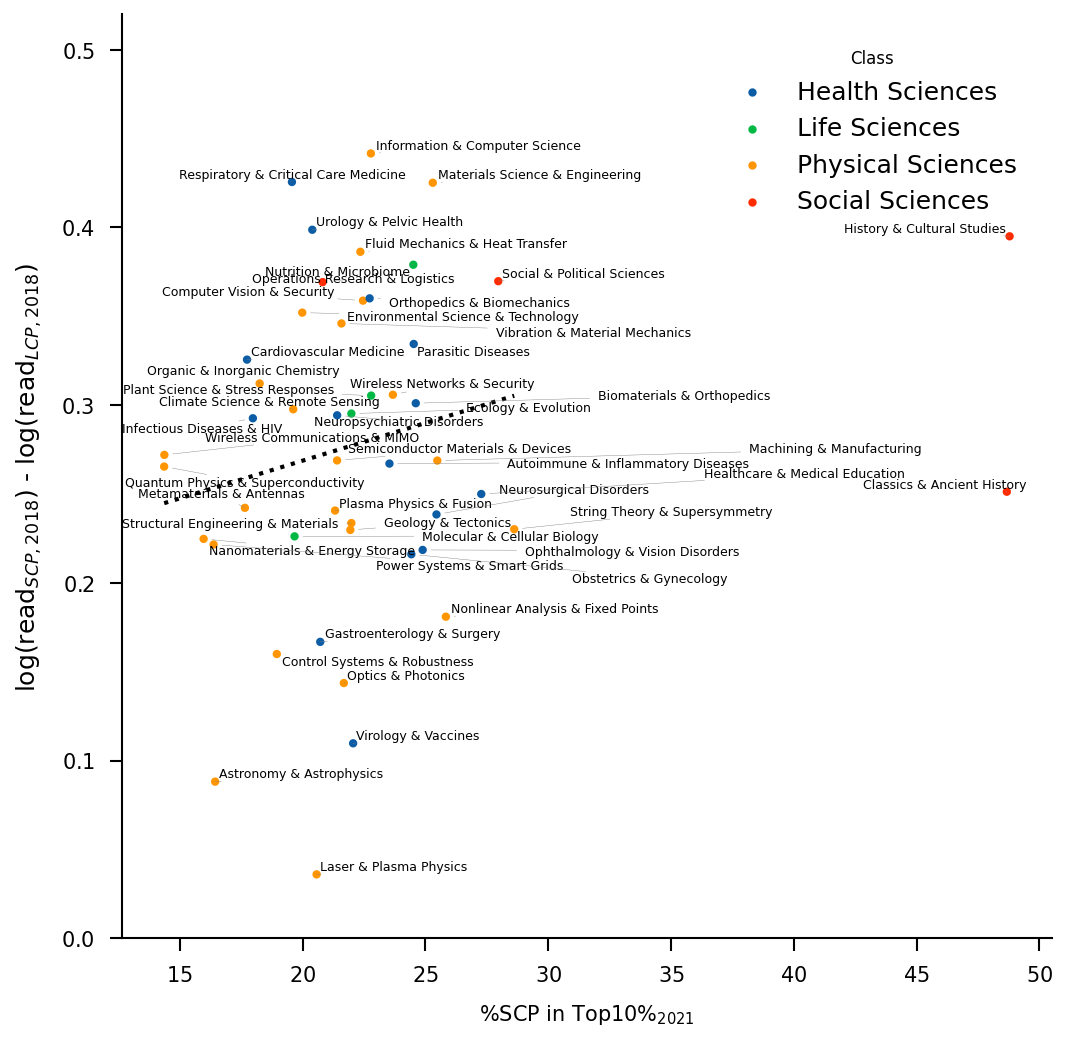

In [63]:
x,y,c = [],[],[]

for partition in range(MAX_PARTITION+1):
    c.append(COLOR_CYCLE[pid_to_largefield[partition]]) #ノードの色
    
    df_slow = papers_slow.query(f'`partition_1e-06` == {partition}')
    df_fast = papers_fast.query(f'`partition_1e-06` == {partition}')
    
    x.append(len(df_slow)*100/(len(df_slow)+len(df_fast))) # マッチしたものだけでなく全体で、2021年のtopに占める、2018年のnot topの割合

    readers_slow_matched = papers_slow_lowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_low_slowmatched2018_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    y.append((readers_slow_matched - readers_low_matched).mean()) #マッチしたものについて、slowをよく読む割合。つまり、今は低くても後々伸びる論文をよく読む強さ
    # journal matchに変更したこと、logとって平均に変更したこと

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y,s=1,c=c)
ax.set_xlabel('%SCP in Top10%$_{2021}$')
ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)',fontsize=6)

texts = [ax.text(xx, yy, keywords[partition], ha='center', va='center',fontsize=3) for xx,yy,partition in zip(x,y,range(MAX_PARTITION+1))]
adjust_text(texts,force_text=(0.1,0.3),arrowprops=dict(arrowstyle='-', color='gray',linewidth=0.1))

# 2と4を除いた相関係数, 近似直線
x_wo24 = [xx for xx,partition in zip(x,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
y_wo24 = [yy for yy,partition in zip(y,range(MAX_PARTITION+1)) if target_partitions_dic[partition] not in [2,4]]
x_fit = [min(x_wo24),max(x_wo24)]
print('r,p=',pearsonr(x_wo24,y_wo24))
coef = np.polyfit(x_wo24,y_wo24,1)
y_fit = np.poly1d(coef)(x_fit)
ax.plot(x_fit,y_fit,linestyle=':',color='black',linewidth=1)

#legendとformat
ax.set_ylim(0,0.52)
for i in range(4):
    ax.scatter([],[],s=1,c=COLOR_CYCLE[i],label=asjc_name[i])
ax.legend(title='Class', title_fontsize=4, frameon=False, fontsize=6, bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1)

plt.savefig('./scp_lcp_field_corr.eps')
plt.show()

## 2.2 doctype

In [265]:
y, y_err = [],[]

papers_havedoctypes = pd.merge(
    papers_slow_lowmatched2018_journal.assign(id=range(len(papers_slow_lowmatched2018_journal))), 
    papers_low_slowmatched2018_journal.assign(id=range(len(papers_low_slowmatched2018_journal))), 
    on='id',
    suffixes=('_slow','_low'),
).dropna(subset=['doctype_slow','doctype_low']).query('doctype_slow == doctype_low')
for doctype in ['ar','cp','re']:
    readers_slow_matched = papers_havedoctypes.query(f'doctype_slow=="{doctype}"')['cumulative_reader_2018_slow'].map(lambda x: np.log(x+1)).values
    readers_low_matched = papers_havedoctypes.query(f'doctype_low=="{doctype}"')['cumulative_reader_2018_low'].map(lambda x: np.log(x+1)).values
    print(doctype, len(readers_slow_matched))
    mean, err = calc_conf(readers_slow_matched - readers_low_matched)
    y.append(mean) 
    y_err.append(err)

ar 32194
cp 2151
re 1308


In [88]:
papers_havedoctypes.shape

(35677, 79)

In [96]:
y, np.exp(y)

([0.2714852241423895, 0.4704661388086695, 0.21194399011598786],
 array([1.31191149, 1.60074019, 1.23607865]))

全体平均 0.31796511768901564


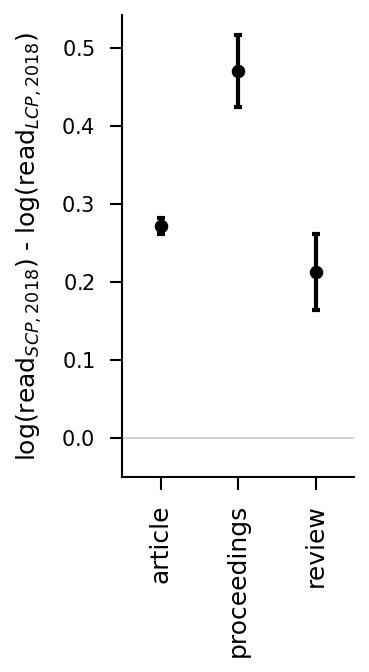

In [93]:
fig,ax = plt.subplots(figsize=(1,2))

x = range(3)
labels = ['article', 'proceedings', 'review']

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{LCP,2018}$)', fontsize=6)

ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.05, ax.get_ylim()[1])

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('../doc/figs_update_11/scp_lcp_doctype.eps')
plt.show()

# 3. fast slow comparison

## 3.1 pairwise analysis

In [39]:
def calc_conf(arr):
    '''
    1次元配列から、平均値・正規分布を仮定した標準誤差、95%信頼区間にする場合は1.96*標準誤差にすること
    '''
    arr_mean = np.mean(arr)
    arr_err = (np.std(arr, ddof=1) / np.sqrt(len(arr))) # = arr.sem()
    return arr_mean, arr_err*1.96

全体平均 -0.06580850692943187
0.048536834713281816
-0.1329283707116034
-0.0874906194474273
-0.06035531587632133


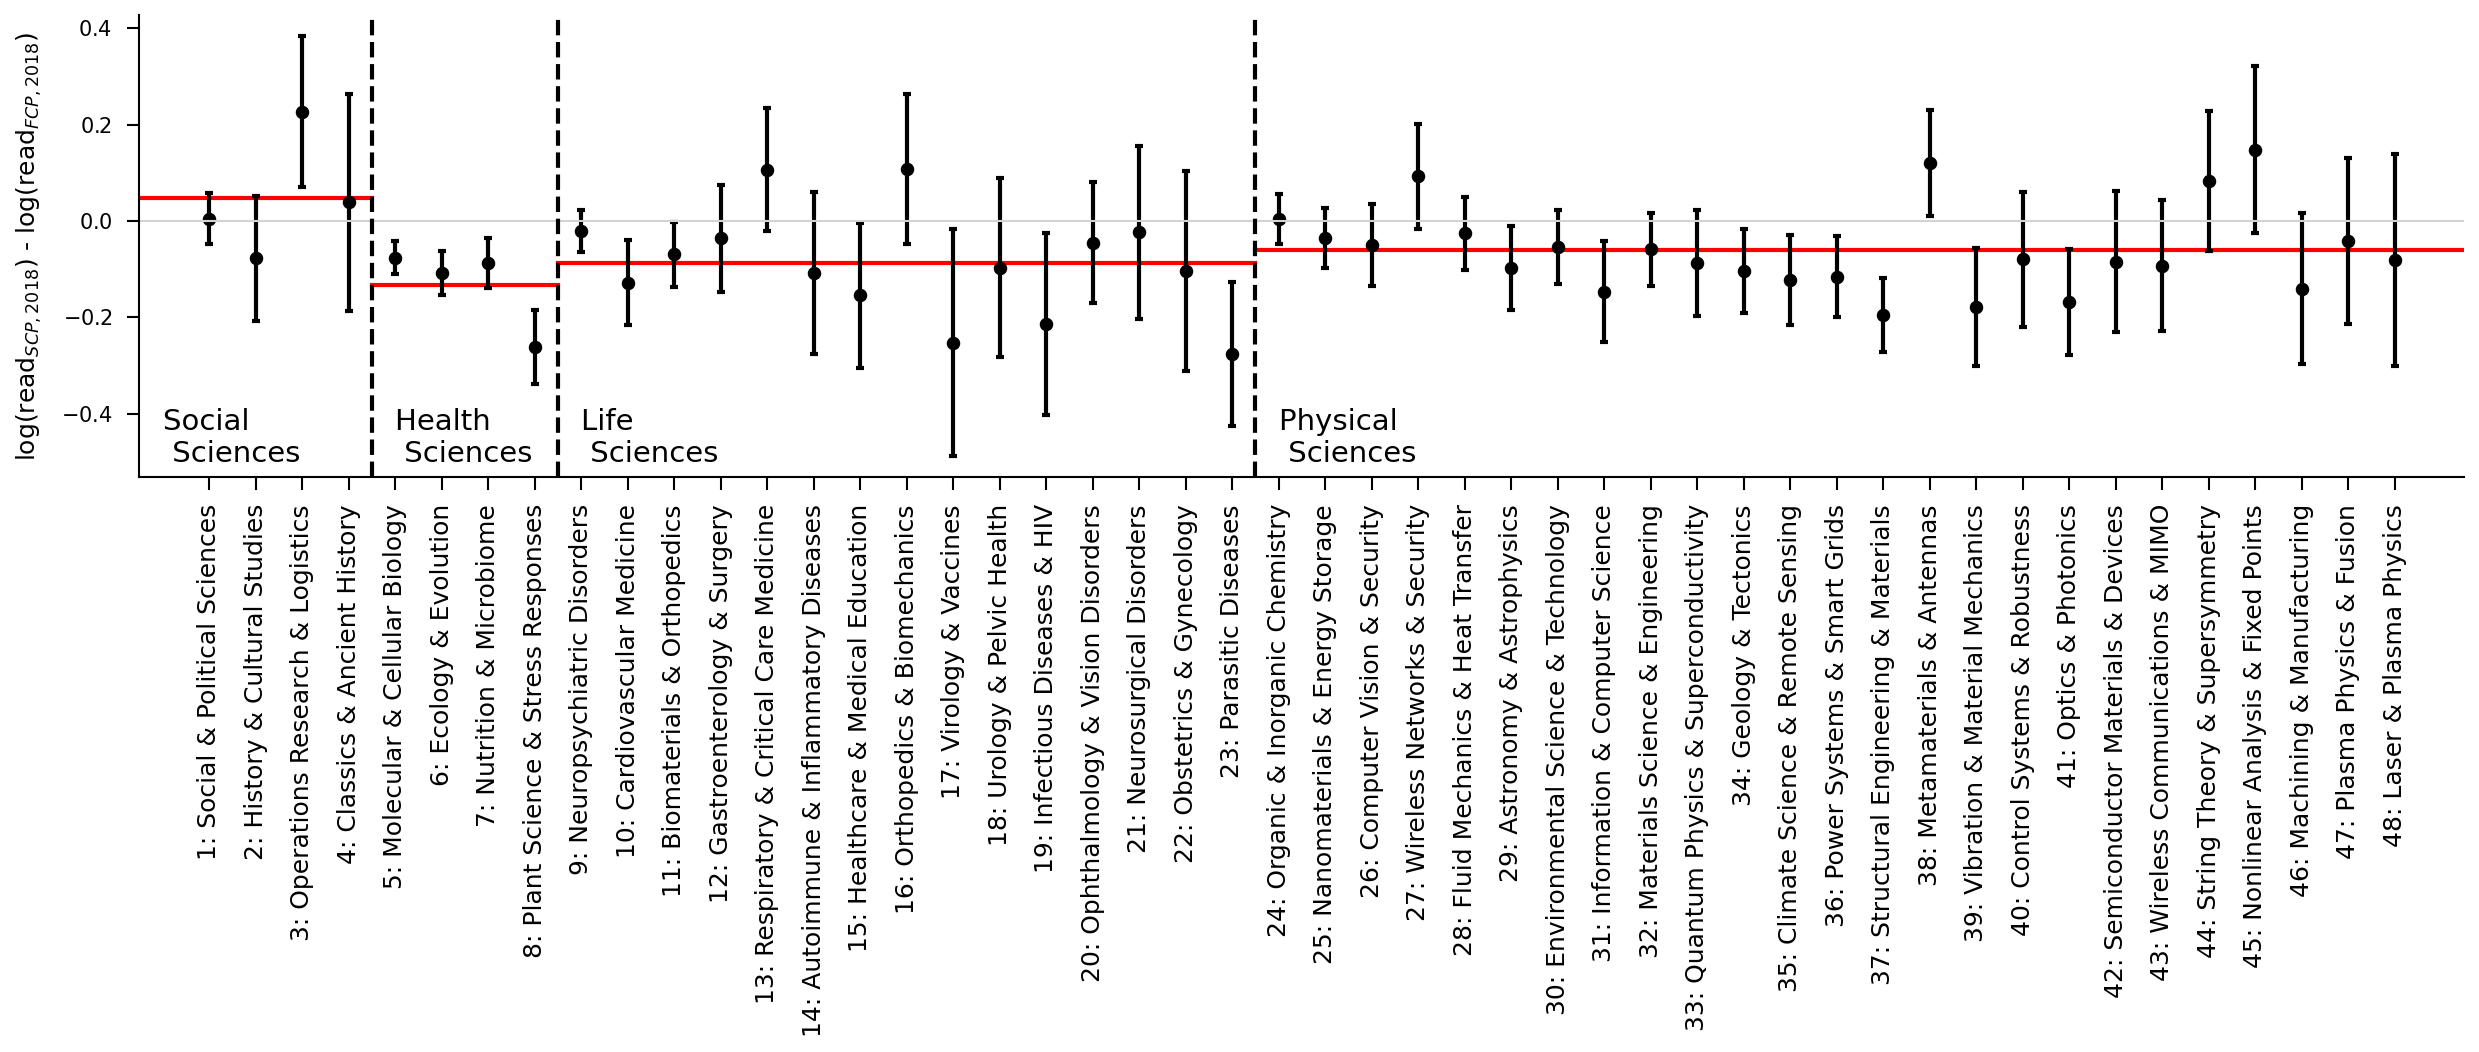

In [52]:
# 2018
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_fastmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_fast_slowmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2018'].map(lambda x: np.log(x+1)).values
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 
print(np.mean(y[:4]))
print(np.mean(y[4:8]))
print(np.mean(y[8:23]))
print(np.mean(y[23:]))

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{FCP,2018}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.5,'Social \n Sciences')
plt.text(4,-0.5,'Health \n Sciences')
plt.text(8,-0.5,'Life \n Sciences')
plt.text(23,-0.5,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_fcp_field_2018.eps')
plt.show()

全体平均 0.056143313611101316
0.15603365712525666
-0.005129131763022418
0.0629458802171973
0.04588290994503867


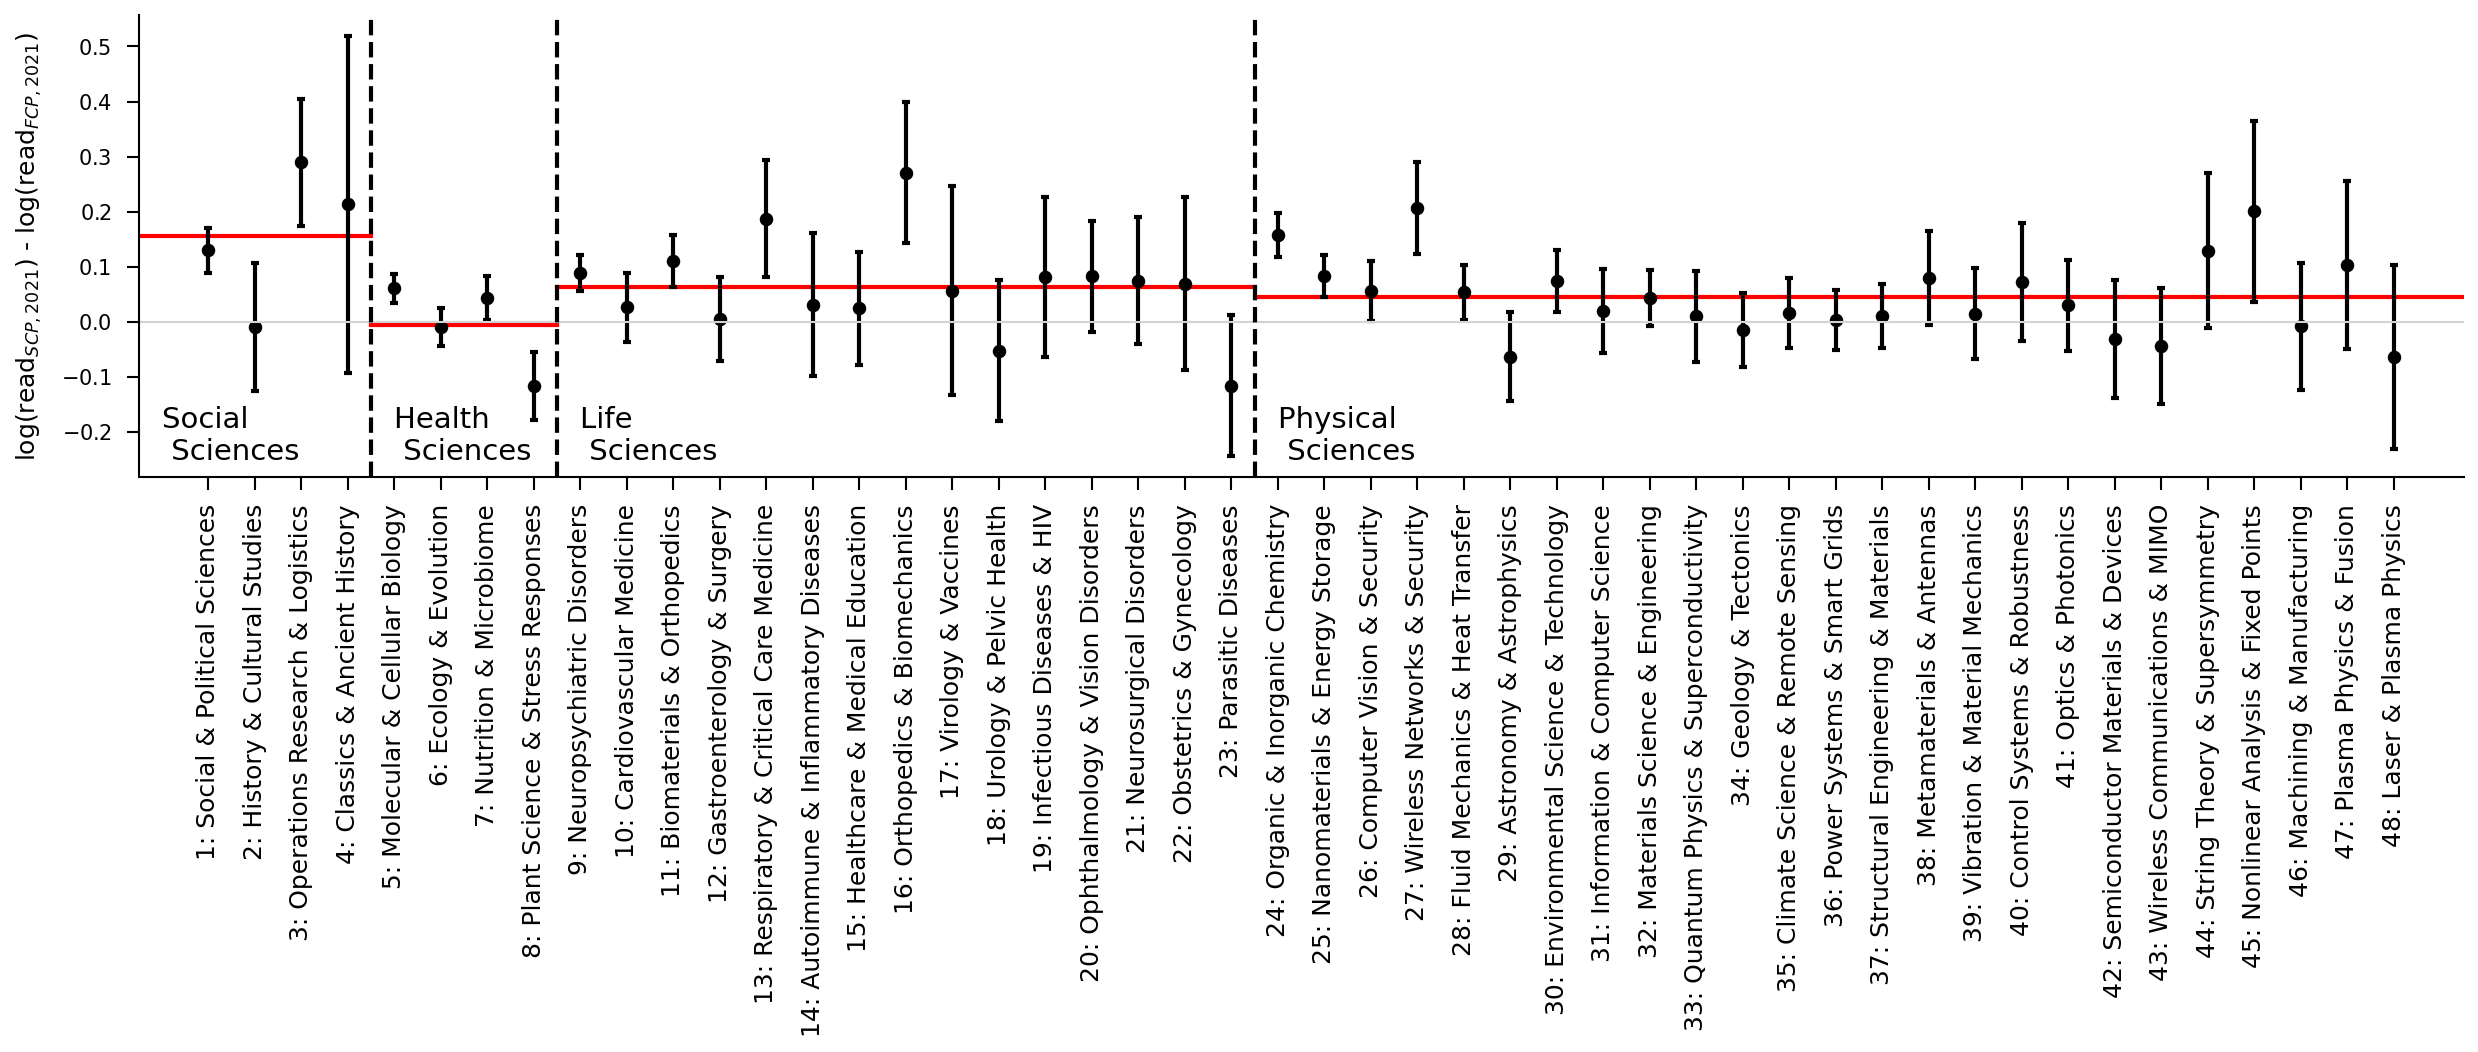

In [42]:
# 2021
y, y_err = [],[]

for partition in target_partitions:
    readers_slow_matched = papers_slow_fastmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2021'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_fast_slowmatched2021_journal.query(f'`partition_1e-06`=={partition}')['cumulative_reader_2021'].map(lambda x: np.log(x+1)).values
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

fig,ax = plt.subplots(figsize=(10,2))

x = range(MAX_PARTITION+1)
labels = [f'{j+1}: ' + keywords[i] for j,i in enumerate(target_partitions)]

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)
ax.axhline(np.mean(y[:4]), xmin=0, xmax=0.1, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[4:8]), xmin=0.1, xmax=0.18, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[8:23]), xmin=0.18, xmax=0.48, linestyle='-', linewidth=1, color='red', zorder=-20) 
ax.axhline(np.mean(y[23:]), xmin=0.48, xmax=1, linestyle='-', linewidth=1, color='red', zorder=-20) 
print(np.mean(y[:4]))
print(np.mean(y[4:8]))
print(np.mean(y[8:23]))
print(np.mean(y[23:]))

ax.axvline(3.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(7.5, linestyle='--', linewidth=1, color='black') 
ax.axvline(22.5, linestyle='--', linewidth=1, color='black') 

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2021}$) - log(read$_{FCP,2021}$)', fontsize=6)
ax.set_xlim(-1.5,48.5)

plt.text(-1,-0.25,'Social \n Sciences')
plt.text(4,-0.25,'Health \n Sciences')
plt.text(8,-0.25,'Life \n Sciences')
plt.text(23,-0.25,'Physical \n Sciences')

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('./scp_fcp_field_2021.eps')
plt.show()

## 3.2 doctype

In [266]:
y, y_err = [],[]

papers_havedoctypes = pd.merge(
    papers_slow_fastmatched2021_journal.assign(id=range(len(papers_slow_fastmatched2021_journal))), 
    papers_fast_slowmatched2021_journal.assign(id=range(len(papers_fast_slowmatched2021_journal))), 
    on='id',
    suffixes=('_slow','_fast'),
).dropna(subset=['doctype_slow','doctype_fast']).query('doctype_slow == doctype_fast')
for doctype in ['ar','cp','re']:
    readers_slow_matched = papers_havedoctypes.query(f'doctype_slow=="{doctype}"')['cumulative_reader_2018_slow'].map(lambda x: np.log(x+1)).values
    readers_fast_matched = papers_havedoctypes.query(f'doctype_fast=="{doctype}"')['cumulative_reader_2018_fast'].map(lambda x: np.log(x+1)).values
    print(doctype, len(readers_slow_matched))
    mean, err = calc_conf(readers_slow_matched - readers_fast_matched)
    y.append(mean) 
    y_err.append(err)

ar 17299
cp 739
re 522


In [108]:
papers_havedoctypes.shape

(18569, 79)

In [109]:
y, np.exp(y)

([-0.06067284990350978, 0.0519078783364693, -0.06573819581741606],
 array([0.94113108, 1.05327871, 0.93637598]))

全体平均 -0.02483438912815218


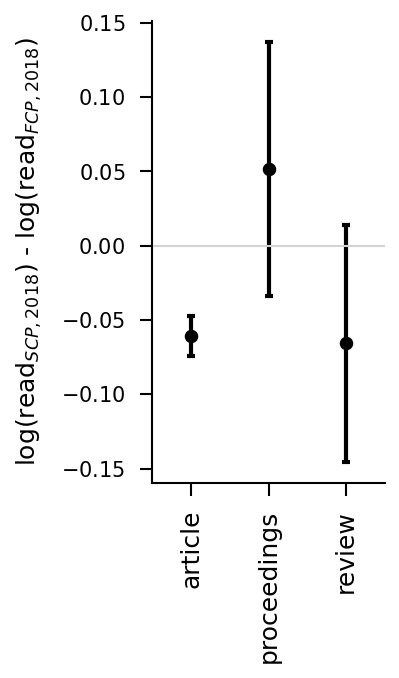

In [111]:
fig,ax = plt.subplots(figsize=(1,2))

x = range(3)
labels = ['article', 'proceedings', 'review']

print('全体平均', np.mean(y))
ax.scatter(x,y, s=5, color='black')
ax.errorbar(x, y, yerr=y_err, capsize=1, linestyle='None', color='black')

ax.axhline(0,c='lightgray',linestyle='-',linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90, fontsize=6)

ax.set_ylabel('log(read$_{SCP,2018}$) - log(read$_{FCP,2018}$)', fontsize=6)

ax.set_xlim(-0.5,2.5)
# ax.set_ylim(-0.05, ax.get_ylim()[1])

# ax.grid(axis='y', alpha=0.8)
# ax.legend(loc='upper right', fontsize=10)

plt.savefig('../doc/figs_update_11/scp_fcp_doctype.eps')
plt.show()